In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
import GPy
import GPyOpt
import copy
import time
import datetime

class Model:
    # Network Parameters
    # n_neurons, learning_rate, num_layers, rnn_type(RNN|BasicLSTM|LSTM|LSTM peelhole)
    # Control Parameters
    # risk_aversion - the margin added to the courtage that leads an buy or sell operation
    # learning_period - how many sequences model should learn before predicting next sequences
    # prediction_period - how many sequences the model should predict
    # max_repeats - how many times in maximum the model should learn
    # min_profit - what is the minimum profit in average during training phase, if the minimum is not reached, the model should not predict
    # gamma - what is the gamma used when preprocessing data
    
    step_profit_list = []
    mixed_domain = [{'name': 'n_neurons', 'type': 'discrete', 'domain': tuple(range(20,160,20))},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (0.001,0.002,0.003,0.004)},
          {'name': 'num_layers', 'type': 'discrete', 'domain': (1,2,3,4)},
          {'name': 'rnn_type', 'type': 'discrete', 'domain': (0,1,2)},
          {'name': 'learning_period', 'type': 'discrete', 'domain': tuple(range(10,41,10))},
          {'name': 'prediction_period', 'type': 'discrete', 'domain': tuple(range(2,11,2))},
          {'name': 'max_repeats', 'type': 'discrete', 'domain': tuple(range(1,52,10))},
          {'name': 'beta', 'type': 'discrete', 'domain': (99, 98)},
          {'name': 'ema', 'type': 'discrete', 'domain': (10,20)},
          {'name': 'time_format', 'type': 'discrete', 'domain': (0,1,2)}, #1 for stepofday, 2 for stepofweek
          {'name': 'volume_input', 'type': 'discrete', 'domain': (0,1)},
          {'name': 'use_centralized_bid', 'type': 'discrete', 'domain': (0,1)},
          {'name': 'split_daily_data', 'type': 'discrete', 'domain': (0,1)},
          {'name': 'related_stock', 'type': 'discrete', 'domain': (0,1)},
         ]
    def __init__(self, regen):
        if regen == False:
            return
        def column_filter(x):
            if x == 'stepofweek':
                return True
            elif 'diff_ema' in x:
                return True
            elif 'volume' in x:
                return True
            elif 'value_ema' in x:
                return True
            else:
                return False
        for ema in (10, 20):
            for beta in (99, 98):
                filename = "data-prep-ema{}-beta{}.csv".format(ema, beta)
                print("pre-processing {}".format(filename))
                data = pd.read_csv(filename, parse_dates=["timestamp"])
                data['dayofweek'] = data['timestamp'].apply(lambda x: x.weekday())
                groups = data.set_index('timestamp').groupby(lambda x: x.date())
                
                # get maximum steps
                max_steps = 0
                for index, df in groups:
                    df_len = len(df)
                    if df_len > max_steps:
                        max_steps = df_len
                        
                np_data = np.zeros((len(groups), max_steps, 30*3+2))
                filtered_columns = list(filter(column_filter, data.columns))
                i = 0
                for index, df in groups:
                    df['stepofday'] = np.arange(0, max_steps)
                    df['stepofweek'] = df['dayofweek'] * max_steps + df['stepofday']
                    np_data[i] = df[filtered_columns + ['stepofweek','stepofday']].to_numpy()
                    i += 1
                    
                numpy_file_name = "np_ema{}_beta{}.npz".format(ema, beta)
                np.savez_compressed(numpy_file_name, np_data)
                

        return
        
    def get_parameter_str(self, X):
        parameter_str = ""
        for i in range(len(self.mixed_domain)):
            parameter_str += self.mixed_domain[i]["name"]
            parameter_str += ':'
            parameter_str += str(X[i])
            parameter_str += ','
        return parameter_str
    
    def reset_graph(self, seed=42):
        tf.reset_default_graph()
        tf.set_random_seed(seed)
        np.random.seed(seed)
        
    
    def log(self, verbose, msg):
        if verbose:
            print(msg)

    def get_batch(self, seq_index, data_train_input, data_train_output):
        X_batch = data_train_input[seq_index:seq_index+1]
        y_batch = data_train_output[seq_index:seq_index+1]
        return X_batch, y_batch
    
    def transform(self, data_all, n_inputs, n_outputs):
        orig_shape = data_all.shape
        data_train_reshape = data_all.reshape((orig_shape[0] * orig_shape[1], orig_shape[2]))
        
        self.scaler_input = preprocessing.MinMaxScaler().fit(data_train_reshape[:,:n_inputs])
        data_train_input_scaled = self.scaler_input.transform(data_train_reshape[:,:n_inputs])
        
        # the invalid step, we change it to zero!
        data_train_input_scaled[~np.any(data_train_reshape, axis=1)] = 0
        data_train_input = data_train_input_scaled.reshape(orig_shape[0], orig_shape[1], n_inputs)
        
        self.scaler_output = preprocessing.MinMaxScaler().fit(data_train_reshape[:,-n_outputs:])
        data_train_output_scaled = self.scaler_output.transform(data_train_reshape[:,-n_outputs:])
        # the invalid step, we change it to zero!
        data_train_output_scaled[~np.any(data_train_reshape, axis=1)] = 0
        data_train_output = data_train_output_scaled.reshape(orig_shape[0], orig_shape[1], n_outputs)
        
        return data_train_input, data_train_output
    
    def inverse_transform_output(self, scaled_outputs):
        outputs_reshaped = scaled_outputs.reshape((scaled_outputs.shape[1], scaled_outputs.shape[2]))
        #outputs = np.exp(self.scaler_output.inverse_transform(outputs_reshaped)) - 1
        outputs = self.scaler_output.inverse_transform(outputs_reshaped)
        return outputs
    
    def inverse_transform_input(self, scaled_inputs):
        inputs_reshaped = scaled_inputs.reshape((scaled_inputs.shape[1], scaled_inputs.shape[2]))
        #inputs_reshaped[:,4:6] = np.exp(self.scaler_input.inverse_transform(inputs_reshaped)[:,4:6]) - 1
        inputs = self.scaler_input.inverse_transform(inputs_reshaped)
        # TODO: the volume and hold should be transformed back.
        return inputs
        
        
    def get_answer(self, features):
        n_neurons = int(features[0])
        learning_rate = features[1]
        num_layers = int(features[2])
        rnn_type = int(features[3])
        learning_period = int(features[4])
        prediction_period = int(features[5])
        max_repeats = int(features[6])
        beta = int(features[7])
        ema = int(features[8])
        time_input = int(features[9])
        volume_input = int(features[10])
        use_centralized_bid = int(features[11])
        split_daily_data = int(features[12])
        related_stock = int(features[13])
        # load data
        file_name = "np_ema{}_beta{}.npz".format(ema, beta)
        data_all = np.load(file_name)['arr_0']
        # pick the data for stock_id
        
        # for the stock 20, the max related stock is 21 (0.94),
        # the medium stock is 18 (0.29), the min related stock is 5 (0.05)
        stock_index = [28]
        
        if related_stock == 1:
            stock_index += [5]
        
        # we must convert the array to 2D
        if use_centralized_bid == 0:
            # remove all the rows for centralized bid. it should be from 9.01 to 17.24, which is 516-12=504 steps
            data_all = data_all[:,7:-5,:]
        
        
        orig_shape = data_all.shape
        print("original shape: ")
        print(orig_shape)

        # make it simple, the step must be even number.
        assert(orig_shape[1] % 2 == 0)
        reshaped_data = data_all.reshape((orig_shape[0] * orig_shape[1], 
                                                          orig_shape[2]))
        
        # the mandatory is the diff.
        input_column_list = [30+i for i in stock_index]
        volume_input_list = stock_index
        if time_input == 1:
            input_column_list = [-1] + input_column_list
        elif time_input == 2:
            input_column_list = [-2] + input_column_list
        if volume_input != 0:
            input_column_list = input_column_list + volume_input_list
            
        output_column_list = [60+i for i in stock_index]
        
        reshaped_data_filtered = reshaped_data[:, input_column_list + output_column_list]
        # for volume we use log.
        if volume_input != 0:
            # the last column is the volume
            last_input_index = len(volume_input_list)
            # we must add 1 to the volume value otherwise log(0) is meaningless.
            reshaped_data_filtered[:, -last_input_index:] = np.log(reshaped_data_filtered[:, -last_input_index:]+1)
        
        n_inputs = len(input_column_list)
        n_outputs = len(output_column_list)
        if split_daily_data == 0:
            data_filtered = reshaped_data[:, input_column_list + output_column_list].reshape((orig_shape[0], 
                                                                                          orig_shape[1], 
                                                                                          n_inputs+n_outputs))

        else:
            # we split day data into 2 parts.
            data_filtered = reshaped_data[:, input_column_list + output_column_list].reshape((orig_shape[0]*2, 
                                                                                          int(orig_shape[1]/2), 
                                                                                          n_inputs+n_outputs))
            learning_period *= 2
            prediction_period *= 2
        
        
        np.nan_to_num(data_filtered, copy=False)
        batch_size = 1
        data_train_input, data_train_output = self.transform(data_filtered, n_inputs, n_outputs)

        # data_train_input in the shape [seq, steps, features]
        days = data_train_input.shape[0]

        max_steps = data_train_input.shape[1]
        print("days={}, max_steps={}".format(days, max_steps))
        self.reset_graph()
        
        X = tf.placeholder(tf.float32, [None, max_steps, n_inputs])
        y = tf.placeholder(tf.float32, [None, max_steps, n_outputs])
        
        layers = None
        if rnn_type == 0:
            layers = [tf.nn.rnn_cell.BasicLSTMCell(n_neurons) 
              for _ in range(num_layers)]
        elif rnn_type == 1:
            layers = [tf.nn.rnn_cell.LSTMCell(n_neurons, use_peepholes=False) 
              for _ in range(num_layers)]
        elif rnn_type == 2:
            layers = [tf.nn.rnn_cell.LSTMCell(n_neurons, use_peepholes=True) 
              for _ in range(num_layers)]
        else:
            print("WRONG")
        cell = tf.nn.rnn_cell.MultiRNNCell(layers)
        
        # For each layer, get the initial state. states will be a tuple of LSTMStateTuples.
        init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, n_neurons])
        state_per_layer_list = tf.unstack(init_state, axis=0)
        rnn_tuple_state = tuple(
            [tf.nn.rnn_cell.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
             for idx in range(num_layers)]
        )

        rnn_outputs, new_states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32, 
                                                    initial_state=rnn_tuple_state)
        
        stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
        stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
        outputs = tf.reshape(stacked_outputs, [-1, max_steps, n_outputs])
        
        
        loss = tf.reduce_mean(tf.square(outputs - y))
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

        # now run the model to get answer:
        rnn_states_before_training = np.zeros((num_layers, 2, batch_size, n_neurons))
        graph_data = []
        my_loss_test_list = []
        my_test_results_list = []
        my_test_answers_list = []
        with tf.Session() as sess:
            init.run()
            for learn_end_seq in range(learning_period, 
                                       days - prediction_period, 
                                       prediction_period):
                learning_start_seq = learn_end_seq - learning_period
                tmp_states = np.zeros((num_layers, 2, batch_size, n_neurons))
                for repeat in range(max_repeats):
                    rnn_states = copy.deepcopy(rnn_states_before_training)
                    my_loss_train_list = []
                    train_asset = 1
                    for seq in range(learning_start_seq, learn_end_seq):
                        X_batch, y_batch = self.get_batch(seq, data_train_input, data_train_output)
                      
                        feed_dict = {
                            X: X_batch,
                            y: y_batch,
                            init_state: rnn_states_before_training
                        }
                        
                        my_op, my_new_states, my_loss_train, my_outputs = sess.run([training_op, new_states, loss, outputs], feed_dict=feed_dict)
                        
                        my_loss_train_list.append(my_loss_train)
                        rnn_states = my_new_states
                        if seq - learning_start_seq == prediction_period:
                            # next training loop starts from here
                            tmp_states = copy.deepcopy(rnn_states)
                    my_loss_train_avg = sum(my_loss_train_list) / len(my_loss_train_list)
                    
                    print("{} sequence:{} - {} repeat={} training finished, training MSE={}".format(
                        datetime.datetime.now().time(),
                        learning_start_seq, learn_end_seq, 
                        repeat, my_loss_train_avg))
                # backup the states after training.
                rnn_states_before_training = copy.deepcopy(tmp_states)
                
                
                for seq in range(learn_end_seq, learn_end_seq + prediction_period):
                    X_test, y_test = self.get_batch(seq, data_train_input, data_train_output)
                    feed_dict = {
                        X: X_test,
                        y: y_test,
                        init_state: rnn_states,
                    }
            
                    my_new_states, my_loss_test, my_outputs = sess.run([new_states, loss, outputs], feed_dict=feed_dict)
                    my_loss_test_list.append(my_loss_test)
                    real_outputs = self.inverse_transform_output(my_outputs)
                    real_test = self.inverse_transform_output(y_test)
                    output_and_answer = np.hstack((real_outputs.reshape((max_steps, n_outputs)), 
                                                   real_test.reshape((max_steps, n_outputs))))
                    my_test_results_list.append(output_and_answer)
                    print("sequence:{} test finished, testing MSE={}".format(seq, my_loss_test))
                    rnn_states = my_new_states
            my_loss_test_avg = sum(my_loss_test_list)/len(my_loss_test_list)
            
            return my_loss_test_avg, np.array(my_test_results_list)
                    
    def opt_wrapper(self, X_list):
        answer = np.zeros((X_list.shape[0], 1))
        for i in range(len(X_list)):
            print(self.get_parameter_str(X_list[i]))
            features = X_list[i]
            answer[i][0], results_list = self.get_answer(features)
            #self.draw_step_profit_graph(self.step_profit_list, "step_profit_{}".format(answer[i][0]))
            #self.step_profit_list = []
            if answer[i][0] < self.min_answer:
                print("find new opt:{}, {}".format(answer[i][0], self.get_parameter_str(X_list[i])))
                self.min_answer = answer[i][0]
            else:
                print("find result:{}, {}".format(answer[i][0], self.get_parameter_str(X_list[i])))
        return answer
                
        
    def optimize(self, max_iter=300):
        self.min_answer = 999
        myBopt = GPyOpt.methods.BayesianOptimization(f=self.opt_wrapper,  # Objective function       
                                             domain=self.mixed_domain,          # Box-constraints of the problem
                                             initial_design_numdata = 20,   # Number data initial design
                                             acquisition_type='EI',        # Expected Improvement
                                             exact_feval = True)           # True evaluations, no sample noise
        
        myBopt.run_optimization(max_iter,eps=0)
    
    
    # no optimize, we have already knew the answer. run it and save the results into file.
    def run(self, n_neurons, learning_rate, 
            num_layers, rnn_type, 
            learning_period, prediction_period, 
            max_repeats, beta, ema, time_input, volume_input,
            use_centralized_bid, split_daily_data, related_stock):
        features = [n_neurons, learning_rate, 
            num_layers, rnn_type, 
            learning_period, prediction_period, 
            max_repeats, beta, ema, time_input, volume_input,
            use_centralized_bid, split_daily_data, related_stock]
        
        answer, my_test_result_list = self.get_answer(features)
        print("Finished, result:{}".format(answer))
        return my_test_result_list


In [7]:
model = Model(False)

In [3]:

model.optimize()

n_neurons:60.0,learning_rate:0.003,num_layers:4.0,rnn_type:0.0,learning_period:30.0,prediction_period:6.0,max_repeats:31.0,beta:98.0,ema:20.0,time_format:1.0,volume_input:1.0,use_centralized_bid:0.0,split_daily_data:0.0,
original shape: 
(61, 504, 92)
days=61, max_steps=504
08:53:37.833107 sequence:0 - 30 repeat=0 training finished, training MSE=0.020649101519181083
08:53:56.660503 sequence:0 - 30 repeat=1 training finished, training MSE=0.0035841716492238146
08:54:15.493890 sequence:0 - 30 repeat=2 training finished, training MSE=0.0032514563218380014
08:54:34.344458 sequence:0 - 30 repeat=3 training finished, training MSE=0.003075166423028956
08:54:53.227790 sequence:0 - 30 repeat=4 training finished, training MSE=0.00295720969637235


KeyboardInterrupt: 

In [8]:
#find result:0.00021723691439287255, n_neurons:120.0,learning_rate:0.001,num_layers:2.0,rnn_type:1.0,learning_period:30.0,prediction_period:4.0,max_repeats:51.0,beta:99.0,ema:10.0,time_format:1.0,
#volume_input:0.0,use_centralized_bid:1.0,split_daily_data:1.0,related_stock:1.0

my_test_result_list = model.run(n_neurons = 120, 
                                learning_rate=0.001, 
                                num_layers=2, 
                                rnn_type=1,
                                learning_period=30, 
                                prediction_period=4, 
                                max_repeats=51, 
                                beta=99, 
                                ema=10,
                                time_input=1,
                                volume_input=0,
                                use_centralized_bid=1,
                                split_daily_data=1,
                                related_stock=1)

original shape: 
(61, 516, 92)
days=122, max_steps=258
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
21:37:08.160026 sequence:0 - 60 repeat=0 training finished, training MSE=0.028525673559245963
21:37:12.266721 sequence:0 - 60 repeat=1 training finished, training MSE=0.004776131470377246
21:37:16.289265 sequence:0 - 60 repeat=2 training finished, training MSE=0.0037873163470067083
21:37:20.461380 sequence:0 - 60 repeat=3 training finished, training MSE=0.0031487213195456813
21:37:24.639773 sequence:0 - 60 repeat=4 training finished, training MSE=0.

21:41:50.236662 sequence:8 - 68 repeat=15 training finished, training MSE=0.00024396265762334225
21:41:54.544182 sequence:8 - 68 repeat=16 training finished, training MSE=0.0002436823821578097
21:41:58.987214 sequence:8 - 68 repeat=17 training finished, training MSE=0.00024334807033786395
21:42:03.007739 sequence:8 - 68 repeat=18 training finished, training MSE=0.00024296842699792856
21:42:07.221554 sequence:8 - 68 repeat=19 training finished, training MSE=0.0002425498560720977
21:42:11.535289 sequence:8 - 68 repeat=20 training finished, training MSE=0.00024209889185537273
21:42:15.585645 sequence:8 - 68 repeat=21 training finished, training MSE=0.00024162014803247683
21:42:20.113616 sequence:8 - 68 repeat=22 training finished, training MSE=0.00024111795076654137
21:42:24.539986 sequence:8 - 68 repeat=23 training finished, training MSE=0.00024059569356419766
21:42:29.088241 sequence:8 - 68 repeat=24 training finished, training MSE=0.00024005632100549217
21:42:33.132254 sequence:8 - 68 

21:47:15.642286 sequence:16 - 76 repeat=44 training finished, training MSE=0.00021250400562469924
21:47:19.555889 sequence:16 - 76 repeat=45 training finished, training MSE=0.00021209076057857602
21:47:23.504166 sequence:16 - 76 repeat=46 training finished, training MSE=0.00021166311998968012
21:47:27.434787 sequence:16 - 76 repeat=47 training finished, training MSE=0.00021124321362246215
21:47:31.328504 sequence:16 - 76 repeat=48 training finished, training MSE=0.00021084341024106833
21:47:35.234074 sequence:16 - 76 repeat=49 training finished, training MSE=0.00021047007733917175
21:47:39.158911 sequence:16 - 76 repeat=50 training finished, training MSE=0.00021012478913083518
sequence:76 test finished, testing MSE=0.0002520759589970112
sequence:77 test finished, testing MSE=0.00011219001316931099
sequence:78 test finished, testing MSE=0.00028589210705831647
sequence:79 test finished, testing MSE=0.0001995457278098911
sequence:80 test finished, testing MSE=0.00035481859231367707
sequen

21:52:13.958977 sequence:32 - 92 repeat=16 training finished, training MSE=0.00024795604391935434
21:52:18.341591 sequence:32 - 92 repeat=17 training finished, training MSE=0.0002478472701720117
21:52:22.593545 sequence:32 - 92 repeat=18 training finished, training MSE=0.0002476161942468025
21:52:26.900486 sequence:32 - 92 repeat=19 training finished, training MSE=0.0002475484789708086
21:52:31.192476 sequence:32 - 92 repeat=20 training finished, training MSE=0.0002472824248494968
21:52:35.446922 sequence:32 - 92 repeat=21 training finished, training MSE=0.00024730810582695995
21:52:39.724690 sequence:32 - 92 repeat=22 training finished, training MSE=0.0002469706490956014
21:52:44.029523 sequence:32 - 92 repeat=23 training finished, training MSE=0.00024719925665219004
21:52:48.343868 sequence:32 - 92 repeat=24 training finished, training MSE=0.00024669905821307717
21:52:52.682120 sequence:32 - 92 repeat=25 training finished, training MSE=0.0002472855094917274
21:52:56.959932 sequence:3

21:57:53.912020 sequence:40 - 100 repeat=44 training finished, training MSE=0.00023924787068002235
21:57:58.196472 sequence:40 - 100 repeat=45 training finished, training MSE=0.0002394397516278938
21:58:02.472635 sequence:40 - 100 repeat=46 training finished, training MSE=0.00023920556329054914
21:58:06.876697 sequence:40 - 100 repeat=47 training finished, training MSE=0.00023954129283083604
21:58:11.253734 sequence:40 - 100 repeat=48 training finished, training MSE=0.0002391837445126536
21:58:15.599733 sequence:40 - 100 repeat=49 training finished, training MSE=0.0002395654048693056
21:58:19.921491 sequence:40 - 100 repeat=50 training finished, training MSE=0.0002390711740493619
sequence:100 test finished, testing MSE=0.00012877215340267867
sequence:101 test finished, testing MSE=7.43185737519525e-05
sequence:102 test finished, testing MSE=0.00010196380753768608
sequence:103 test finished, testing MSE=0.00012858684931416065
sequence:104 test finished, testing MSE=0.0001499577483627945

In [9]:
np.save('results.np', my_test_result_list)

In [31]:
filename = "data-prep-ema{}-beta{}.csv".format(10,99)
data = pd.read_csv(filename, parse_dates=["timestamp"])

In [32]:
data

,Unnamed: 0,timestamp,volume_0,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,...,value_ema_10_beta_99_20,value_ema_10_beta_99_21,value_ema_10_beta_99_22,value_ema_10_beta_99_23,value_ema_10_beta_99_24,value_ema_10_beta_99_25,value_ema_10_beta_99_26,value_ema_10_beta_99_27,value_ema_10_beta_99_28,value_ema_10_beta_99_29
0,0,2019-01-28 08:54:00+01:00,42269.333333,3898.5,4333.333333,1029.833333,2636.166667,36514.833333,3446.333333,866.0,...,-0.001478,-0.001131,0.000557,-0.001047,6.063878e-04,0.000114,-0.000464,-0.002209,0.000699,0.000467
1,1,2019-01-28 08:55:00+01:00,42269.333333,3898.5,4333.333333,1029.833333,2636.166667,36514.833333,3446.333333,866.0,...,-0.001338,-0.000901,0.000963,-0.001277,8.374173e-04,0.000254,-0.000249,-0.002208,0.000777,0.000607
2,2,2019-01-28 08:56:00+01:00,42269.333333,3898.5,4333.333333,1029.833333,2636.166667,36514.833333,3446.333333,866.0,...,-0.000862,-0.000356,0.001619,-0.001295,9.042973e-04,0.000370,-0.000093,-0.002175,0.001017,0.000871
3,3,2019-01-28 08:57:00+01:00,42269.333333,3898.5,4333.333333,1029.833333,2636.166667,36514.833333,3446.333333,866.0,...,-0.000579,0.000172,0.002119,-0.001312,9.193709e-04,0.000625,0.000116,-0.002114,0.001266,0.001091
4,4,2019-01-28 08:58:00+01:00,42269.333333,3898.5,4333.333333,1029.833333,2636.166667,36514.833333,3446.333333,866.0,...,-0.000601,0.000015,0.002490,-0.001387,7.660496e-04,0.000811,0.000328,-0.002216,0.001301,0.001496
5,5,2019-01-28 08:59:00+01:00,42269.333333,3898.5,4333.333333,1029.833333,2636.166667,36514.833333,3446.333333,866.0,...,-0.000620,0.000044,0.002801,-0.001044,8.919316e-04,0.000939,0.000543,-0.002454,0.001580,0.001906
6,6,2019-01-28 09:00:00+01:00,42269.333333,3898.5,4333.333333,1029.833333,2636.166667,36514.833333,3446.333333,866.0,...,-0.000636,0.000107,0.003064,-0.000821,1.039445e-03,0.001021,0.000762,-0.002841,0.001862,0.002028
7,7,2019-01-28 09:01:00+01:00,33663.000000,3509.0,2.000000,80.000000,1446.000000,6469.000000,4986.000000,1725.0,...,-0.000024,0.000502,0.003250,-0.000638,1.311261e-03,0.001090,0.001532,-0.002756,0.002039,0.002443
8,8,2019-01-28 09:02:00+01:00,35419.000000,2208.0,1013.000000,23347.000000,5917.000000,20017.000000,4085.000000,620.0,...,0.000831,0.001422,0.003254,0.000208,1.125758e-03,0.000877,0.002017,-0.001767,0.002665,0.002627
9,9,2019-01-28 09:03:00+01:00,15519.000000,12989.0,166.000000,0.000000,4040.000000,11809.000000,4043.000000,178.0,...,0.001130,0.001820,0.003062,0.000720,6.504076e-04,0.001366,0.002215,-0.001154,0.002966,0.002539


In [33]:
ori_shape = my_test_result_list.shape

df = pd.DataFrame(my_test_result_list.reshape(ori_shape[0]*ori_shape[1], ori_shape[2]))

In [34]:
df

,0,1,2,3
0,-0.000995,-0.004927,-3.034084e-03,7.017584e-03
1,0.000198,0.001424,-3.057469e-03,5.920222e-03
2,-0.000176,0.000941,-2.772137e-03,5.066268e-03
3,-0.000418,0.001692,-2.281147e-03,4.590330e-03
4,-0.000695,0.001980,-1.875829e-03,4.250651e-03
5,-0.000883,0.002080,-1.578806e-03,3.984659e-03
6,-0.001079,0.001757,-1.259688e-03,3.857314e-03
7,-0.001033,0.001863,-1.178537e-03,3.741294e-03
8,-0.001259,0.000976,-8.494572e-04,3.748583e-03
9,-0.001243,0.001178,-5.752985e-04,3.609524e-03


In [35]:
len(my_test_result_list)

56

In [36]:
df.corr()

,0,1,2,3
0,1.000000,0.054006,0.572192,0.004038
1,0.054006,1.000000,0.054242,0.665037
2,0.572192,0.054242,1.000000,0.110281
3,0.004038,0.665037,0.110281,1.000000


In [37]:
groups = data.set_index('timestamp').groupby(lambda x: x.date())

In [38]:
data

,Unnamed: 0,timestamp,volume_0,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,...,value_ema_10_beta_99_20,value_ema_10_beta_99_21,value_ema_10_beta_99_22,value_ema_10_beta_99_23,value_ema_10_beta_99_24,value_ema_10_beta_99_25,value_ema_10_beta_99_26,value_ema_10_beta_99_27,value_ema_10_beta_99_28,value_ema_10_beta_99_29
0,0,2019-01-28 08:54:00+01:00,42269.333333,3898.5,4333.333333,1029.833333,2636.166667,36514.833333,3446.333333,866.0,...,-0.001478,-0.001131,0.000557,-0.001047,6.063878e-04,0.000114,-0.000464,-0.002209,0.000699,0.000467
1,1,2019-01-28 08:55:00+01:00,42269.333333,3898.5,4333.333333,1029.833333,2636.166667,36514.833333,3446.333333,866.0,...,-0.001338,-0.000901,0.000963,-0.001277,8.374173e-04,0.000254,-0.000249,-0.002208,0.000777,0.000607
2,2,2019-01-28 08:56:00+01:00,42269.333333,3898.5,4333.333333,1029.833333,2636.166667,36514.833333,3446.333333,866.0,...,-0.000862,-0.000356,0.001619,-0.001295,9.042973e-04,0.000370,-0.000093,-0.002175,0.001017,0.000871
3,3,2019-01-28 08:57:00+01:00,42269.333333,3898.5,4333.333333,1029.833333,2636.166667,36514.833333,3446.333333,866.0,...,-0.000579,0.000172,0.002119,-0.001312,9.193709e-04,0.000625,0.000116,-0.002114,0.001266,0.001091
4,4,2019-01-28 08:58:00+01:00,42269.333333,3898.5,4333.333333,1029.833333,2636.166667,36514.833333,3446.333333,866.0,...,-0.000601,0.000015,0.002490,-0.001387,7.660496e-04,0.000811,0.000328,-0.002216,0.001301,0.001496
5,5,2019-01-28 08:59:00+01:00,42269.333333,3898.5,4333.333333,1029.833333,2636.166667,36514.833333,3446.333333,866.0,...,-0.000620,0.000044,0.002801,-0.001044,8.919316e-04,0.000939,0.000543,-0.002454,0.001580,0.001906
6,6,2019-01-28 09:00:00+01:00,42269.333333,3898.5,4333.333333,1029.833333,2636.166667,36514.833333,3446.333333,866.0,...,-0.000636,0.000107,0.003064,-0.000821,1.039445e-03,0.001021,0.000762,-0.002841,0.001862,0.002028
7,7,2019-01-28 09:01:00+01:00,33663.000000,3509.0,2.000000,80.000000,1446.000000,6469.000000,4986.000000,1725.0,...,-0.000024,0.000502,0.003250,-0.000638,1.311261e-03,0.001090,0.001532,-0.002756,0.002039,0.002443
8,8,2019-01-28 09:02:00+01:00,35419.000000,2208.0,1013.000000,23347.000000,5917.000000,20017.000000,4085.000000,620.0,...,0.000831,0.001422,0.003254,0.000208,1.125758e-03,0.000877,0.002017,-0.001767,0.002665,0.002627
9,9,2019-01-28 09:03:00+01:00,15519.000000,12989.0,166.000000,0.000000,4040.000000,11809.000000,4043.000000,178.0,...,0.001130,0.001820,0.003062,0.000720,6.504076e-04,0.001366,0.002215,-0.001154,0.002966,0.002539


In [40]:
# start day is the learning period.
ori_shape = my_test_result_list.shape
my_test_result_list = my_test_result_list.reshape(int(ori_shape[0]/2), ori_shape[1]*2, ori_shape[2])
start_day = 30
i = 0
my_df_list = []
for index, df in groups:
    print("handling day: {}".format(i))
    if i >= start_day and i-start_day < len(my_test_result_list):
        print(i)
        my_df = df[['last_20','value_ema_10_beta_99_20','last_5','value_ema_10_beta_99_5']]
        print(len(my_test_result_list[i-start_day,:,0]))
        print(len(my_df))
        my_df['test_y_20'] = my_test_result_list[i-start_day,:,0]
        my_df['test_y_5'] = my_test_result_list[i - start_day,:,1] 
        my_df['valid_y_20'] = my_test_result_list[i - start_day,:,2]
        my_df['valid_y_5'] = my_test_result_list[i - start_day,:,3]
        my_df_list.append(my_df)
        
    i+=1
   



handling day: 0
handling day: 1
handling day: 2
handling day: 3
handling day: 4
handling day: 5
handling day: 6
handling day: 7
handling day: 8
handling day: 9
handling day: 10
handling day: 11
handling day: 12
handling day: 13
handling day: 14
handling day: 15
handling day: 16
handling day: 17
handling day: 18
handling day: 19
handling day: 20
handling day: 21
handling day: 22
handling day: 23
handling day: 24
handling day: 25
handling day: 26
handling day: 27
handling day: 28
handling day: 29
handling day: 30
30
516
516
handling day: 31
31
516
516
handling day: 32
32
516
516
handling day: 33
33
516
516
handling day: 34
34
516
516
handling day: 35
35
516
516
handling day: 36
36
516
516
handling day: 37
37
516
516
handling day: 38
38
516
516
handling day: 39
39
516
516
handling day: 40
40
516
516
handling day: 41
41
516
516
handling day: 42
42
516
516
handling day: 43
43
516
516
handling day: 44
44
516
516
handling day: 45
45
516
516
handling day: 46
46
516
516
handling day: 47
47
516


In [41]:
my_df_list[-1]


,last_20,value_ema_10_beta_99_20,last_5,value_ema_10_beta_99_5,test_y_20,test_y_5,valid_y_20,valid_y_5
timestamp,,,,,,,,
2019-04-17 08:54:00+02:00,276.00,-0.002838,78.330000,-0.001159,0.001468,-0.003683,1.420003e-03,1.184600e-03
2019-04-17 08:55:00+02:00,275.80,-0.002904,78.316667,-0.001148,0.000746,0.000748,1.814786e-03,9.893193e-04
2019-04-17 08:56:00+02:00,275.60,-0.002589,78.303333,-0.000707,0.000457,0.000706,2.117542e-03,8.766524e-04
2019-04-17 08:57:00+02:00,275.40,-0.002382,78.290000,-0.000313,0.000819,0.001284,2.184992e-03,6.134891e-04
2019-04-17 08:58:00+02:00,275.20,-0.002081,78.276667,-0.000020,0.000984,0.000953,2.178205e-03,4.651710e-04
2019-04-17 08:59:00+02:00,275.00,-0.001764,78.263333,0.000360,0.000803,0.000973,2.176599e-03,2.943533e-04
2019-04-17 09:00:00+02:00,274.80,-0.001371,78.250000,0.000663,0.001053,0.000551,1.926143e-03,3.042368e-04
2019-04-17 09:01:00+02:00,275.20,-0.001497,78.130000,0.001302,0.001251,0.000442,1.649768e-03,2.683643e-04
2019-04-17 09:02:00+02:00,274.90,-0.001343,78.200000,0.001604,0.001155,0.000299,1.357973e-03,2.157949e-04


In [43]:
buy_threshold = 9.17555532e-05
sell_threshold = -9.62431518e-04
min_hold_steps = 61
tot_profit = 1
tot_stock_profit = 1
result_list = []
for day_idx in range(len(my_df_list)):
    print("starting day {}".format(day_idx))
    trades = 0
    daily_profit = 1
    state = 0
    df = my_df_list[day_idx]
    for step in range(len(df)):
        if df.iloc[step]['test_y_20'] > buy_threshold and state == 0:
            price = df.iloc[step]['last_20']
            print("buy at step {} price:{}".format(step, price))
            state = 1
            last_step = step
        elif state==1 and ((df.iloc[step]['test_y_20'] < buy_threshold and step - last_step > min_hold_steps) or step == len(df) - 1):
            last_price = price
            price = df.iloc[step]['last_20']
            print("sell at step {} price:{}".format(step, price))
            profit = (price - last_price)/last_price
            tot_profit *= (1+profit)
            daily_profit *= (1 + profit)
            state = 0
            trades += 1
    last = df.iloc[len(df)-1].last_20
    open = df.iloc[0].last_20
    stock_profit = (last - open) / open
    tot_stock_profit *= (1+stock_profit)
    
    result_list.append([day_idx, trades, tot_stock_profit, tot_profit])
    print("finishing day {}, daily_profit:{}".format(day_idx, daily_profit))
print(tot_profit)

starting day 0
buy at step 1 price:240.725
sell at step 71 price:239.7
buy at step 76 price:239.9
sell at step 138 price:241.25
buy at step 141 price:240.85
sell at step 203 price:241.5
buy at step 216 price:241.9
sell at step 278 price:242.075
buy at step 280 price:242.15
sell at step 343 price:241.8
buy at step 348 price:242.0
sell at step 410 price:242.65
buy at step 422 price:243.0
sell at step 515 price:243.8
finishing day 0, daily_profit:1.009328763497152
starting day 1
buy at step 1 price:244.04166666666669
sell at step 63 price:244.8
buy at step 105 price:245.35
sell at step 167 price:244.9
buy at step 172 price:244.75
sell at step 234 price:243.25
buy at step 242 price:243.1
sell at step 305 price:244.15
buy at step 324 price:243.95
sell at step 386 price:244.1
buy at step 393 price:244.53333333333333
sell at step 515 price:244.4
finishing day 1, daily_profit:0.9994985370945656
starting day 2
buy at step 1 price:244.26666666666668
sell at step 63 price:244.5
buy at step 65 pri

sell at step 309 price:270.5
buy at step 311 price:270.8
sell at step 373 price:269.9
buy at step 375 price:269.5
sell at step 515 price:270.3
finishing day 19, daily_profit:1.0261851240558149
starting day 20
buy at step 0 price:270.3
sell at step 62 price:268.5
buy at step 67 price:268.5
sell at step 129 price:268.1
buy at step 134 price:267.8
sell at step 196 price:268.5
buy at step 207 price:268.4
sell at step 269 price:269.2
buy at step 295 price:268.7
sell at step 357 price:268.7
buy at step 364 price:268.7
sell at step 426 price:267.6
finishing day 20, daily_profit:0.9933343923343417
starting day 21
buy at step 0 price:269.2
sell at step 62 price:269.6
buy at step 74 price:270.0
sell at step 136 price:270.1
buy at step 176 price:270.3
sell at step 238 price:270.1
buy at step 260 price:269.8
sell at step 322 price:270.1
buy at step 330 price:269.9
sell at step 392 price:267.9
finishing day 21, daily_profit:0.9948020206282214
starting day 22
buy at step 0 price:268.6
sell at step 6

In [44]:
result_df = pd.DataFrame(result_list, columns=['day','trades','stock','profit'])
result_df

,day,trades,stock,profit
0,0,7,1.012879,1.009329
1,1,6,1.015372,1.008823
2,2,6,1.023058,1.013902
3,3,7,1.034483,1.021368
4,4,7,1.039884,1.028443
5,5,6,1.041130,1.031012
6,6,7,1.062734,1.048700
7,7,7,1.042792,1.032660
8,8,7,1.049024,1.036970
9,9,7,1.023058,1.016836


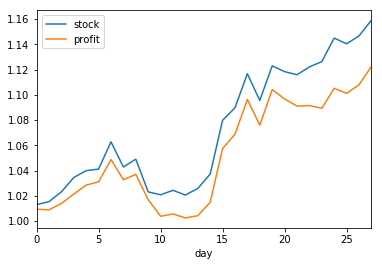

In [45]:
result_df[['day','stock','profit']].plot(x='day')

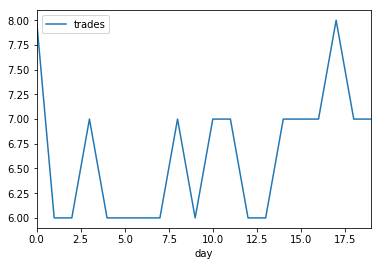

In [86]:
result_df[['day','trades']].plot(x='day')

In [53]:
 mixed_domain = [{'name': 'buy_threshold', 'type': 'continuous', 'domain': (0.0, 0.001)},
                 {'name': 'sell_threshold', 'type': 'continuous', 'domain': (-0.001, 0.0)},
                 {'name': 'min_hold_steps', 'type': 'discrete', 'domain': range(10,100)},
         ]
    

    
def opt_wrapper(X_list):
    
    print(X_list)
    buy_threshold = X_list[0][0]
    sell_threshold = X_list[0][1]
    min_hold_steps = int(X_list[0][2])
    tot_profit = 1
    tot_stock_profit = 1
    last_step = None
    max_trades = 2
    for day_idx in range(len(my_df_list)):
        #print("starting day {}".format(day_idx))
        trades = 0
        daily_profit = 1
        state = 0
        df = my_df_list[day_idx]
        for step in range(len(df)):
            if state == 0 and trades<max_trades:
                if df.iloc[step]['test_y_5'] > buy_threshold:
                    price = df.iloc[step]['last_5']
                    hold = 5
                elif df.iloc[step]['test_y_20'] > buy_threshold:
                    price = df.iloc[step]['last_20']
                    hold = 20
                    #print("buy at step {} price:{}".format(step, price))
                state = 1
                last_step = step
            elif state == 1:
                if (df.iloc[step]['test_y_'+str(hold)] < buy_threshold and 
                    step - last_step > min_hold_steps) or step == len(df)-1:
                    
                    last_price = price
                    price = df.iloc[step]['last_'+str(hold)]
                    #print("sell at step {} price:{}".format(step, price))
                    profit = (price - last_price)/last_price
                    tot_profit *= (1+profit)
                    daily_profit *= (1 + profit)
                    state = 0
                    hold = 0
                    trades += 1
        last = df.iloc[len(df)-1].last_20
        open = df.iloc[0].last_20
        stock_profit = (last - open) / open
        tot_stock_profit *= (1+stock_profit)
        #print("finishing day {}, daily_profit:{}".format(day_idx, daily_profit))
    print("{}, profit:{}".format(X_list, tot_profit))
    return -tot_profit
    


In [49]:
myBopt = GPyOpt.methods.BayesianOptimization(opt_wrapper,  # Objective function       
                                     domain=mixed_domain,          # Box-constraints of the problem
                                     initial_design_numdata = 20,   # Number data initial design
                                     acquisition_type='EI',        # Expected Improvement
                                     exact_feval = True)           # True evaluations, no sample noise

myBopt.run_optimization(100,eps=0)

[[ 5.39768670e-04 -6.33489296e-04  1.20000000e+01]]
[[ 5.39768670e-04 -6.33489296e-04  1.20000000e+01]], profit:1.0815382361492298
[[ 9.72982371e-04 -5.82727747e-04  2.30000000e+01]]
[[ 9.72982371e-04 -5.82727747e-04  2.30000000e+01]], profit:1.072348495644462
[[ 4.38491784e-04 -9.75878182e-04  3.90000000e+01]]
[[ 4.38491784e-04 -9.75878182e-04  3.90000000e+01]], profit:1.0466641641539387
[[ 4.78160773e-04 -9.20840547e-04  9.40000000e+01]]
[[ 4.78160773e-04 -9.20840547e-04  9.40000000e+01]], profit:1.0437683746080237
[[ 7.94184330e-04 -4.27459147e-04  8.30000000e+01]]
[[ 7.94184330e-04 -4.27459147e-04  8.30000000e+01]], profit:1.0946373186953977
[[ 9.26689901e-05 -9.64701067e-04  8.60000000e+01]]
[[ 9.26689901e-05 -9.64701067e-04  8.60000000e+01]], profit:1.0863130069114684
[[ 9.74345624e-04 -9.13212071e-04  1.00000000e+01]]
[[ 9.74345624e-04 -9.13212071e-04  1.00000000e+01]], profit:1.0699428201922554
[[ 1.88098378e-04 -2.84223481e-04  1.90000000e+01]]
[[ 1.88098378e-04 -2.84223481e-0

[[ 8.20149749e-04 -8.45584369e-04  6.50000000e+01]]
[[ 8.20149749e-04 -8.45584369e-04  6.50000000e+01]], profit:1.1144818640126415
[[ 8.92573061e-04 -8.40800715e-04  6.50000000e+01]]
[[ 8.92573061e-04 -8.40800715e-04  6.50000000e+01]], profit:1.1289200959087007
[[ 8.94853423e-04 -8.85863311e-04  6.50000000e+01]]
[[ 8.94853423e-04 -8.85863311e-04  6.50000000e+01]], profit:1.1299593049074677
[[ 9.35522313e-04 -8.86182027e-04  6.50000000e+01]]
[[ 9.35522313e-04 -8.86182027e-04  6.50000000e+01]], profit:1.1265728014500331
[[ 9.11650767e-04 -9.41684025e-04  6.50000000e+01]]
[[ 9.11650767e-04 -9.41684025e-04  6.50000000e+01]], profit:1.1297223975771713
[[ 9.61472772e-04 -9.63012910e-04  6.50000000e+01]]
[[ 9.61472772e-04 -9.63012910e-04  6.50000000e+01]], profit:1.1256775492801185
[[ 7.85115546e-04 -6.74780314e-04  6.50000000e+01]]
[[ 7.85115546e-04 -6.74780314e-04  6.50000000e+01]], profit:1.1220587334442897
[[ 8.50411149e-04 -6.30239495e-04  6.50000000e+01]]
[[ 8.50411149e-04 -6.30239495e-

In [82]:
my_df[['test_y','valid_y']].corr()

,test_y,valid_y
test_y,1.000000,0.711176
valid_y,0.711176,1.000000


In [83]:
my_df['diff']=my_df['test_y']-my_df['valid_y']

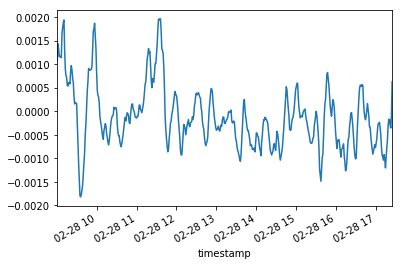

In [84]:
my_df['diff'].plot()

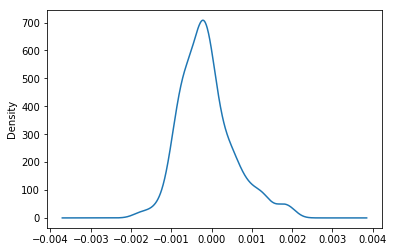

In [85]:
my_df['diff'].plot.kde()

In [86]:
my_df['diff'].mean()

-0.0001233379876338359

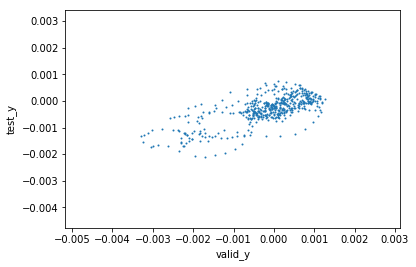

In [87]:
my_df.plot.scatter(x='valid_y', y='test_y',s=1)

In [88]:
my_df['diff'].max()

0.0019612595114189297

In [89]:
my_df.loc[my_df['valid_y'].argmax()]

last_20                    249.150000
value_ema_20_beta_98_20      0.001258
test_y                       0.000055
valid_y                      0.001258
diff                        -0.001203
Name: 2019-02-28 17:14:00+01:00, dtype: float64

In [90]:
my_df

,last_20,value_ema_20_beta_98_20,test_y,valid_y,diff
timestamp,,,,,
2019-02-28 09:01:00+01:00,252.20,-0.000660,0.000436,-0.000660,0.001096
2019-02-28 09:02:00+01:00,252.20,-0.001085,0.000346,-0.001085,0.001431
2019-02-28 09:03:00+01:00,251.75,-0.001291,0.000019,-0.001291,0.001310
2019-02-28 09:04:00+01:00,251.70,-0.001432,-0.000275,-0.001432,0.001157
2019-02-28 09:05:00+01:00,251.80,-0.001604,-0.000437,-0.001604,0.001168
2019-02-28 09:06:00+01:00,251.60,-0.001784,-0.000627,-0.001784,0.001157
2019-02-28 09:07:00+01:00,251.55,-0.001903,-0.000764,-0.001903,0.001138
2019-02-28 09:08:00+01:00,252.10,-0.002196,-0.000552,-0.002196,0.001645
2019-02-28 09:09:00+01:00,251.65,-0.002346,-0.000570,-0.002346,0.001775


In [91]:
buy_threshold = 0.0005
sell_threshold = -0.0005

action_steps = my_df[my_df['test_y']>0.0005].append(my_df[my_df['test_y']<-0.0005]).sort_values('timestamp')

In [92]:
state = 0
profit = 1
for i in range(len(my_df)):
    row = my_df.iloc[i]
    if row['test_y'] > 0.0001 and state == 0:
        print("buy at {} price:{}".format(row.index, row.last_20))
        state = 1
        price = row.last_20
    elif row['test_y'] < -0.0001 and state == 1:
        state = 0
        ratio = (row.last_20 - price) / price
        print("sell at {} price:{}".format(row.index, row.last_20)) 
        if ratio != 0:
            profit = profit * ratio
print("profit={}".format(profit))

buy at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:252.2
sell at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:251.7
buy at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:250.8
sell at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:250.55
buy at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:249.95
sell at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:249.7
buy at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:247.55
sell at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:247.35
buy at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:247.8
se

In [69]:
action_steps

,last_20,value_ema_20_beta_98_20,test_y,valid_y,diff
timestamp,,,,,
2019-02-26 09:02:00+01:00,255.60,-0.000461,-0.000537,-0.000461,-0.000076
2019-02-26 09:09:00+01:00,255.45,-0.000057,-0.000570,-0.000057,-0.000513
2019-02-26 09:10:00+01:00,255.35,0.000170,-0.000696,0.000170,-0.000866
2019-02-26 09:11:00+01:00,255.35,0.000364,-0.000770,0.000364,-0.001135
2019-02-26 09:12:00+01:00,255.40,0.000603,-0.000773,0.000603,-0.001377
2019-02-26 09:13:00+01:00,255.40,0.000887,-0.000745,0.000887,-0.001632
2019-02-26 09:14:00+01:00,255.40,0.001151,-0.000699,0.001151,-0.001850
2019-02-26 09:23:00+01:00,256.40,0.000542,0.000507,0.000542,-0.000035
2019-02-26 09:24:00+01:00,256.40,0.000193,0.000623,0.000193,0.000430
